# Copy Files from drive

In [ ]:
!pip install numpy -U
!pip install pyLDAvis

In [1]:
# Copy Original Data files
%cp /content/drive/MyDrive/Archive.zip ./

In [3]:
!mkdir ./data

In [4]:
!unzip ./Archive.zip -d ./data/

Archive:  ./Archive.zip
  inflating: ./data/yelp_academic_dataset_business.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_business.json  
  inflating: ./data/yelp_academic_dataset_checkin.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_checkin.json  
  inflating: ./data/yelp_academic_dataset_review_restaurants_toronto.csv  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_review_restaurants_toronto.csv  
  inflating: ./data/yelp_academic_dataset_tip.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_tip.json  
  inflating: ./data/yelp_academic_dataset_user.json  
  inflating: ./data/__MACOSX/._yelp_academic_dataset_user.json  


In [5]:
# Copy Final files post preprocessing/feature Engineering
%cp /content/drive/MyDrive/rest_rev.zip ./
!unzip ./rest_rev.zip -d ./

Archive:  ./rest_rev.zip
   creating: ./data2/
  inflating: ./data2/restaurants_data.csv  
  inflating: ./data2/reviews_dataset.csv  
   creating: ./data2/ldamodel/
  inflating: ./data2/ldamodel/lda.model.id2word  
  inflating: ./data2/ldamodel/lda.model.expElogbeta.npy  
  inflating: ./data2/ldamodel/lda.model.state  
  inflating: ./data2/ldamodel/lda.model  
  inflating: ./data2/user_dataset.csv  
  inflating: ./data2/checkin_dataset.csv  
  inflating: ./data2/restaurants_dataset.csv  


In [43]:
## Change these path variables based on your file directories

chat_words_file_path = "/content/chat_words.json"
emoticon_file_path = "/content/Emoticon.json"


res_path = "./data/yelp_academic_dataset_business.json"
chk_path = "./data/yelp_academic_dataset_checkin.json"
rev_path = "/content/data/yelp_academic_dataset_review_restaurants_toronto.csv"


## Import Libraries

In [2]:
import numpy as np
from ast import literal_eval
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter

#

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import operator
import seaborn as sns
#from spellchecker import SpellChecker
from wordcloud import WordCloud
from collections import Counter

import gensim
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from gensim import models
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook(local=True)
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
from nltk.stem import WordNetLemmatizer

import json
import folium
import string
import ast
import seaborn as sns
from scipy.stats import iqr
from google.colab.patches import cv2_imshow

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Function to read datas
def read_file(path):
    data_file = open(path)
    data = []
    for line in data_file:
        data.append(json.loads(line))

    data_frame = pd.DataFrame(data)
    data_file.close()
    return data_frame

In [4]:
# Read Restaurant, Checkin and User Data

#res_path = "./data/yelp_academic_dataset_business.json"
#chk_path = "./data/yelp_academic_dataset_checkin.json"

df_res = read_file(res_path)
df_chk = read_file(chk_path)
print(df_res.shape)

# Filter for toronto
df_res = df_res[df_res['city']=='Toronto']
df_res = df_res[df_res['categories'].str.contains('Restaurants', na=False)].reset_index(drop=True)
#df_res.head(3)

(209393, 14)


# Restaurant Data

In [5]:
df_res.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.633291,-79.531768,3.0,13,0,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",None
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,1,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","Vietnamese, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
2,8k62wYhDVq1-652YbJi5eg,Tim Hortons,90 Adelaide Street W,Toronto,ON,M5H 3V9,43.649859,-79.382060,3.0,8,1,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",None


## Preprocessing and EDA

<Axes: xlabel='review_count', ylabel='Density'>

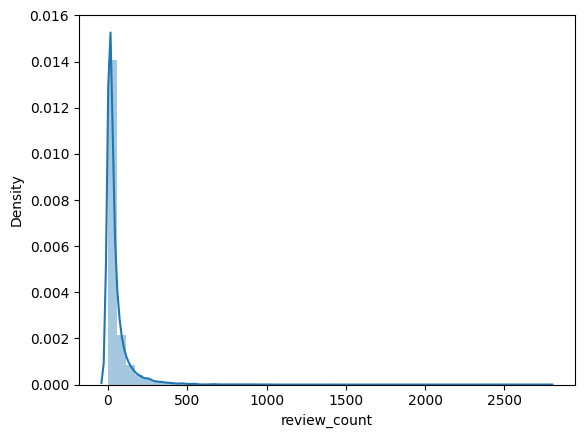

In [6]:
# Review count
sns.distplot(df_res['review_count'])

In [7]:
# Restaurants which have more than 4 stars and recieved the most ratings
## Restaurants that recieved highest number of reviews are near Yonge St and King St
## Also the restaurants that recieved the highest number of reviews are near the university line
## Sunbway - Line 1

d2_map = df_res.sort_values(by='review_count', ascending=False)[:30]

geo_data = d2_map[['latitude', 'longitude', 'name']]
map = folium.Map(location=[geo_data['latitude'].mean(), geo_data['longitude'].mean()], zoom_start=14, control_scale=True)

for index, loc_info in geo_data.iterrows():
    folium.Marker([loc_info['latitude'], loc_info['longitude']], popup=loc_info['name']).add_to(map)

map

## Data Wrangling

In [8]:
# Exploding columns of attribute and categories, hours

# Data wrangling - format the dictionary to readable format
def wrangle_attributes(row, col_name):
    attributes_data = row

    if (pd.isnull(attributes_data)):
        row = '{}'
        return row

    attributes_data = attributes_data.replace("\"u\'", "\'")
    attributes_data = attributes_data.replace('\'', '\"')
    attributes_data = attributes_data.replace('""', '"')
    attributes_data = attributes_data.replace('"{', '{')
    attributes_data = attributes_data.replace('}"', '}')
    attributes_data = attributes_data.replace(' False', ' "False"')
    attributes_data = attributes_data.replace(' True', ' "True"')
    attributes_data = attributes_data.replace(' None', ' "None"')

    row = attributes_data
    return row

d1 = df_res.copy()
d1 = pd.concat([d1.drop(['attributes'], axis=1), d1['attributes'].apply(pd.Series)], axis=1)
cols = ['BusinessParking', 'Ambience', 'GoodForMeal', 'Music']

for i in cols:
    # print(i)
    try:
        d1[i] = d1[i].apply(lambda x: wrangle_attributes(x, i))
    except AttributeError as e:
        pass
    d1[i] = d1[i].apply(lambda x: literal_eval(x))
    d1 = pd.concat([d1.drop([i], axis=1), d1[i].apply(pd.Series)], axis=1)

hours = d1['hours'].apply(pd.Series)
d1 = pd.concat([d1.drop(['hours'], axis=1), d1['hours'].apply(pd.Series)], axis=1)

In [9]:
# Drop columns with more than 40% missing values

def null_data(df):
    null_per = {"column":[],"percent_missing":[]}
    cols = df.columns.to_list()
    for i in cols:
        null_count = np.round(df[i].isna().sum()/df.shape[0], 2)*100
        null_per["column"].append(i)
        null_per["percent_missing"].append(null_count)
    return pd.DataFrame.from_dict(null_per)

missing_df = null_data(d1).sort_values(by="percent_missing", ascending=False)
missing_columns = missing_df[missing_df['percent_missing']>=39]['column'].to_list()

d1.drop(missing_columns, axis=1, inplace=True)

In [10]:
# 3 stars or more restaurants
d1 = d1[d1['stars']>=3]

In [11]:
# Drop Unnecessary columns
drop_cols = ["name", "city", "state", "postal_code"]
d1.drop(drop_cols, axis=1, inplace=True)

In [13]:
## Convert week columns to rows
columns = d1.columns.to_list()
not_string = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
d1 = d1.melt(id_vars=[x for x in columns if x not in not_string],
             var_name='Day',
             value_name='operating_hours')

In [14]:
# Get day of week custom column to merge with checkin data later on
weekday_dict = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
d1['weekday'] = d1['Day'].map(weekday_dict).astype(int)

In [16]:
# Variables - Numerical and Categorical
columns = d1.columns.to_list()
numerical = [x for x in columns if d1[x].dtype != 'O']
categorical = [x for x in columns if x not in numerical]

In [17]:
# Replace None with nan
for i in categorical:
    d1[i].replace('None', np.nan, inplace=True)

In [18]:
# Check which are flag - Dichotomus and Polychotomus
flag_vars = []
non_flag = []

for i in categorical:
  if d1[i].nunique() == 2:
    flag_vars.append(i)
  else:
    non_flag.append(i)

In [19]:
# Replace True and False with 1 and 0
map_val = {"True":1, "False":0}
for i in flag_vars:
  d1[i] = d1[i].map(map_val)

In [20]:
## Hours of operartion

# Extract start and End time and convert to datetime
d1[['start_time', 'end_time']] = d1['operating_hours'].str.split('-', expand=True)
d1['start_time'] = pd.to_datetime(d1['start_time'], format="%H:%M")
d1['end_time'] = pd.to_datetime(d1['end_time'], format="%H:%M")

# Compute the hourly difference b/w start and end time
def calc_difference(df):
    diff_val = []
    for i in range(len(df)):
      # If past 12 midnight, add another day so that results are not negative
      if (df['end_time'][i] < df['start_time'][i]):
          df['end_time'][i] = df['end_time'][i] + pd.Timedelta(days=1)
          diff_val.append((df['end_time'][i] - df['start_time'][i])/ np.timedelta64(1, 'h'))
      else:
          diff_val.append((df['end_time'][i] - df['start_time'][i])/ np.timedelta64(1, 'h'))

    df['duration'] = diff_val
    return df

d1 = calc_difference(d1)
d1.drop(['operating_hours', 'start_time', 'end_time'], axis=1, inplace=True)
non_flag.remove('operating_hours')


In [21]:
# Categorical Variables with less than 10 unique
cat_discrete = []

for i in non_flag:
    if d1[i].nunique()<10:
        cat_discrete.append(i)
        print(f"Variable: ({i}) \nUnique Values: {d1[i].unique()}\n")
        #print(d1[i].unique(), '\n')

Variable: (RestaurantsPriceRange2) 
Unique Values: ['2' '1' '3' nan '4']

Variable: (RestaurantsAttire) 
Unique Values: ["u'casual'" "'casual'" nan "u'dressy'" "'dressy'" "u'formal'" "'formal'"]

Variable: (Alcohol) 
Unique Values: ["u'none'" "u'beer_and_wine'" "'none'" nan "u'full_bar'" "'beer_and_wine'"
 "'full_bar'"]

Variable: (NoiseLevel) 
Unique Values: ["u'average'" nan "'loud'" "u'loud'" "'average'" "u'quiet'" "u'very_loud'"
 "'quiet'" "'very_loud'"]

Variable: (WiFi) 
Unique Values: ["'no'" "u'no'" "u'free'" "'free'" nan "u'paid'" "'paid'"]

Variable: (Day) 
Unique Values: ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']



In [22]:
# Replace unicode string with string and fill nan with mode
d2 = d1.copy()

def literal_return(val):
    try:
        return ast.literal_eval(val)
    except ValueError:
        return (val)

d2["RestaurantsAttire"] = d2["RestaurantsAttire"].apply(lambda x: literal_return(x))
d2['Alcohol'] = d2['Alcohol'].apply(lambda x: literal_return(x))
d2['Alcohol'].replace('none', np.nan, inplace=True)
d2['NoiseLevel'] = d2['NoiseLevel'].apply(lambda x: literal_return(x))
d2['WiFi'] = d2['WiFi'].apply(lambda x: literal_return(x))

d2[cat_discrete] = d2[cat_discrete].fillna(d2[cat_discrete].mode().iloc[0])
cat_discrete.remove('NoiseLevel')

In [23]:
# Perform one hot encoding
for i in cat_discrete:
    d2 = pd.concat([d2, pd.get_dummies(d2[i], prefix=i)], axis=1)
    d2.drop(i, axis=1, inplace=True)

In [24]:
# Ordinal Encoding on Noise level
noise_level = {"quiet":1, "average":2, "loud":3, "very_loud":4}
d2['NoiseLevel'] = d2['NoiseLevel'].map(noise_level)

In [25]:
# Get Number of categories as column for categories
d2['categories'] = d2['categories'].apply(lambda x: len(x.split(',')))

In [26]:
# drop rows where all missing data
nan_cols = null_data(d2)
nan_cols = nan_cols[nan_cols['percent_missing']>0]['column'].values

d3 = d2.dropna(subset=nan_cols, how='any')

## Restaurants in vicinity

In [29]:
_## Competitors in vicinity

import math

def km_to_degrees(latitude, longitude, km_distance):
    # Earth's approximate radius in km
    earth_radius_km = 6371.0

    # Convert distance in kilometers to distance in degrees for both latitude and longitude
    lat_range = (km_distance / earth_radius_km) * (180.0 / math.pi)
    long_range = (km_distance / earth_radius_km) * (180.0 / math.pi) / math.cos(latitude * math.pi / 180.0)

    return lat_range, long_range

def calculate_range_around_point(latitude, longitude, km_distance):
    lat_range, long_range = km_to_degrees(latitude, longitude, km_distance)

    min_latitude = latitude - lat_range
    max_latitude = latitude + lat_range

    min_longitude = longitude - long_range
    max_longitude = longitude + long_range

    return min_latitude, max_latitude, min_longitude, max_longitude


def get_restaurants_nearby(df, lat, long, name):

    # Compute a 1 km radius around the lat long get min and max of lat/long
    min_lat, max_lat, min_long, max_long = calculate_range_around_point(lat, long, 0.3)

    # Get the restaurants data in vicinity
    df_vic = df[(df['latitude']>min_lat) & (df['latitude']<max_lat) & (df['longitude']<max_long) & (df['longitude']>min_long)]
    df_vic = df_vic[['latitude', 'longitude', 'business_id']]

    return {name:len(df_vic)}

    """
    # Create a map of the data
    map = folium.Map(location = [lat, long],
                     zoom_start=14,
                     control_scale=True)
    for index, df_vic in df_vic.iterrows():
      folium.Marker([df_vic['latitude'], df_vic['longitude']],
                     popup = df_vic['name']).add_to(map)

    # Add the restaurant of interest to the map
    folium.Marker([lat, long],
                  popup=name,
                  icon=folium.Icon(color='red')).add_to(map)

    # Draw Circle
    folium.Circle([lat, long],
                  radius = 400).add_to(map)

    return map
    """

In [30]:
res_nearby = {}

for i in range(len(df_res)):
    nam, lat, lon = df_res.loc[i,"business_id"], df_res.loc[i,"latitude"], df_res.loc[i,"longitude"]
    count_nearby = get_restaurants_nearby(df_res, lat, lon, nam)
    res_nearby.update(count_nearby)

In [31]:
competitors_nearby = pd.DataFrame(res_nearby.items(), columns=['business_id', 'competitors_count'])

In [32]:
d3 = d3.merge(competitors_nearby, on='business_id')

In [33]:
# Restaurant Data post Preprocessing
d3.head(3)

,business_id,address,latitude,longitude,stars,review_count,is_open,categories,HasTV,GoodForKids,RestaurantsGoodForGroups,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,NoiseLevel,OutdoorSeating,garage,street,validated,lot,valet,romantic,intimate,classy,hipster,touristy,trendy,upscale,casual,weekday,duration,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsAttire_casual,RestaurantsAttire_dressy,RestaurantsAttire_formal,Alcohol_beer_and_wine,Alcohol_full_bar,WiFi_free,WiFi_no,WiFi_paid,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,competitors_count
0,0QjROMVW9ACKjhSEfHqNCQ,688 Gerrard Street E,43.666376,-79.348773,4.0,116,1,2,1.0,1.0,1.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,11.0,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,27
1,0QjROMVW9ACKjhSEfHqNCQ,688 Gerrard Street E,43.666376,-79.348773,4.0,116,1,2,1.0,1.0,1.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,11.0,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,27
2,0QjROMVW9ACKjhSEfHqNCQ,688 Gerrard Street E,43.666376,-79.348773,4.0,116,1,2,1.0,1.0,1.0,1.0,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,10.0,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,27


In [62]:
# Save File to csv
d3.to_csv('./data2/restaurants_dataset.csv', index=None)

# Check-in Data

In [34]:
df_chk.head(3)

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."


In [35]:
# Explode the Checkin column

d4 = df_chk.copy()

d4['date'] = d4['date'].apply(lambda x: x.split(',')) # Create a list from string
d4 = d4.explode('date').reset_index(drop=True)
d4['date'] = d4['date'].apply(lambda x: x.strip()) # Remove Beginning, Tailing whitespaces

d5 = d4.copy()
d5['date'] = pd.to_datetime(d5['date'], format='%Y-%m-%d %H:%M:%S')
d5['weekday'] = d5['date'].dt.dayofweek

# Get the checkin count each weekday
dd = d5.groupby(['business_id', 'weekday'])['weekday'].count().rename('checkin').reset_index()

In [36]:
# Create flag variable for target
dd['flag_target'] = np.where(dd['checkin']>dd['checkin'].median(), 1, 0)

In [37]:
dd.head(3)

,business_id,weekday,checkin,flag_target
0,--1UhMGODdWsrMastO9DZw,1,3,0
1,--1UhMGODdWsrMastO9DZw,2,1,0
2,--1UhMGODdWsrMastO9DZw,3,1,0


In [38]:
# Save File to CSV
dd.to_csv('./data2/checkin_data.csv', index=None)

# Reviews Data

In [44]:
# Read Data, Drop nan rows, Keep required columns, create column for length of review

df_r = pd.read_csv(rev_path)
df_r.dropna(subset=['text'], how='all', inplace=True)
df_r = df_r[df_r['business_id'].isin(d3['business_id'])]
df_r = df_r[['business_id', 'user_id', 'review_id', 'text', 'date']]
df_r['text_len'] = df_r['text'].apply(lambda x: len(x.split()))
df_r = df_r[df_r['text_len']>5].reset_index(drop=True)

## Text Cleaning

In [40]:
# 3. Remove Hyperlinks

pattern = '(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])'

def find_hyperlinks(text):
  pat_search = re.sub(pattern, "", text)
  if not pat_search:
    pass
  else:
    return pat_search

In [41]:
## 4. Remove Emoji

def find_emoji(text):
    try:
        emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)

        emojis = emoji_pattern.sub(" ", text)
        if not emojis:
          pass
        else:
          return emojis
    except Exception as e:
        print(e, text)

In [47]:
## 5. Remove Emoicon

with open(emoticon_file_path, "r") as f:
    emoticon = json.load(f)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in emoticon) + u')')
    return emoticon_pattern.sub(r'', text)

In [46]:
# 6. Remove Chat words


with open(chat_words_file_path, "r") as f:
    chat_words_list = []
    chat_words_map_dict = json.load(f)
    chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

In [48]:
# 7. Removal of punctuations

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [49]:
# 9. Removal of stopwords

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

In [50]:
# 10. Lemmatization

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [51]:
df_rev = df_r.copy()

# 1.  lowercase
df_rev['text'] = df_rev['text'].apply(lambda x: x.lower())

# 2. whitespaces
df_rev['text'] = df_rev['text'].apply(lambda x: " ".join(x.split()))

# 3. Hyperlinks
df_rev['text'] = df_rev['text'].apply(lambda x: find_hyperlinks(x))

# 5. Emoticon
df_rev['text'] = df_rev['text'].apply(lambda x: remove_emoticons(x))

# 4. Emoji
df_rev['text'] = df_rev['text'].apply(lambda x: find_emoji(x))

# 6. chat words
df_rev['text'] = df_rev['text'].apply(lambda x: chat_words_conversion(x))

# 7. Punctuations
df_rev['text'] = df_rev['text'].apply(lambda x: remove_punctuation(x))

# 8. Non English words removed
df_rev['text'] = df_rev['text'].apply(lambda x: re.sub('[^a-z0-9]', " ", x))

# 9. Stopwords
df_rev['text'] = df_rev['text'].apply(lambda x: remove_stopwords(x))

# 10. Lemmatization
df_rev['text'] = df_rev['text'].apply(lambda x: lemmatize_words(x))

In [52]:
## Removal of most frequent words

cnt = Counter()
for text in df_rev["text"].values:
    for word in text.split():
        cnt[word] += 1

com_15 = cnt.most_common(15)
com_15_val = []
for i in com_15:
    com_15_val.append(i[0])
com_15_val = "|".join(com_15_val)
df_rev['text'] = df_rev['text'].apply(lambda x: re.sub(com_15_val, "", x))

# 11. whitespaces
df_rev['text'] = df_rev['text'].apply(lambda x: " ".join(x.split()))

## WordCloud

In [ ]:
# Visualize Wordcloud

long_string = ','.join(list(df_rev['text'].values))

wordcloud = WordCloud(background_color = "white",
                      contour_width=3,
                      max_words=350,
                      max_font_size = 400,
                      width=1020,
                      height=512,
                      contour_color = 'steelblue'
                      )

wcloud = wordcloud.generate(long_string)

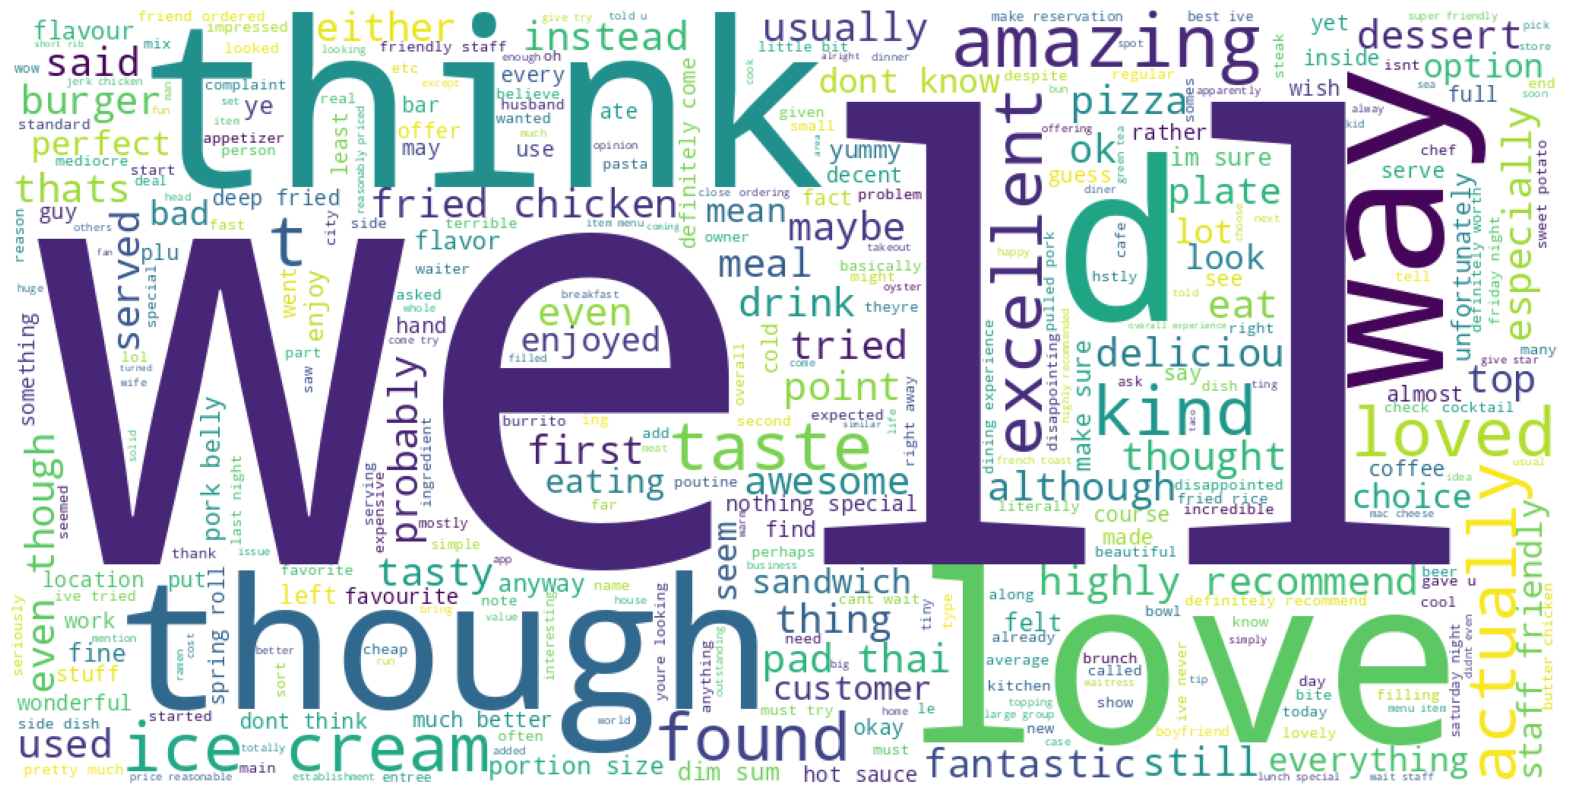

In [ ]:
# Plot the word cloud

plt.figure(figsize=(20,20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## LDA Topic Modelling

In [53]:
## LDA Topic Modeling

stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))
             if word not in stop_words] for doc in texts]

data = df_rev['text'].values.tolist()
data_words = list(sent_to_words(data))


# remove stop words
data_words = remove_stopwords(data_words)


In [54]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [55]:
# Save / Load topic model
#!mkdir ./data2/ldamodel
#lda_model.save("./data2/ldamodel/lda.model")

# Load model
lda_model = models.ldamodel.LdaModel.load("./data2/ldamodel/lda.model")

In [56]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"chicken" + 0.012*"rice" + 0.012*"pork" + 0.012*"fried" + '
  '0.011*"soup" + 0.011*"noodle" + 0.010*"dish" + 0.010*"beef" + 0.008*"sauce" '
  '+ 0.007*"meat"'),
 (1,
  '0.017*"dish" + 0.010*"menu" + 0.010*"delicious" + 0.010*"dessert" + '
  '0.009*"steak" + 0.008*"wine" + 0.008*"meal" + 0.008*"dinner" + 0.008*"well" '
  '+ 0.008*"amazing"'),
 (2,
  '0.026*"dish" + 0.023*"lobster" + 0.020*"thai" + 0.017*"curry" + '
  '0.017*"sauce" + 0.016*"rice" + 0.015*"crab" + 0.014*"fried" + '
  '0.014*"shrimp" + 0.012*"flavour"'),
 (3,
  '0.022*"cheese" + 0.022*"pizza" + 0.020*"sandwich" + 0.016*"sauce" + '
  '0.012*"salad" + 0.010*"fry" + 0.009*"meat" + 0.009*"pie" + 0.008*"bread" + '
  '0.008*"pasta"'),
 (4,
  '0.057*"burger" + 0.028*"fry" + 0.021*"taco" + 0.009*"chip" + 0.009*"patty" '
  '+ 0.008*"best" + 0.007*"fish" + 0.007*"try" + 0.007*"vegan" + 0.007*"ive"'),
 (5,
  '0.022*"pancake" + 0.021*"egg" + 0.016*"brunch" + 0.015*"cream" + '
  '0.015*"breakfast" + 0.013*"coffee" + 0.0

In [57]:
# Visualize the LDA topic model
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.151472 -0.075468       1        1  22.811591
6      0.178696  0.014035       2        1  14.430109
0     -0.047340 -0.051227       3        1  12.379600
1     -0.027375  0.025710       4        1  12.379226
8      0.152581  0.003779       5        1  10.577273
3     -0.084819  0.037956       6        1   7.400512
5     -0.080173  0.222652       7        1   6.081934
4      0.024237  0.019591       8        1   5.519128
9     -0.072366 -0.091252       9        1   4.216455
2     -0.194913 -0.105776      10        1   4.204174, topic_info=         Term          Freq         Total Category  logprob  loglift
256    burger  52062.000000  52062.000000  Default  30.0000  30.0000
122      dish  85034.000000  85034.000000  Default  29.0000  29.0000
203     sushi  31186.000000  31186.000000  Default  28.0000  28.0000
673   chicken  82674.000000  82674.000000  Default  27.0000  27.0000
529       fry  42208.000000  42208.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1021     beef   3561.926871  39314.080100  Topic10  -5.2802   0.7678
52    ordered   4031.098962  82904.853233  Topic10  -5.1565   0.1454
80      style   2828.897582  14317.890167  Topic10  -5.5106   1.5475
205    tasted   2901.207838  23090.633381  Topic10  -5.4854   1.0948
309       bit   3074.960885  53629.088529  Topic10  -5.4272   0.3103

[823 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
7315       9  0.998474         aburi
10289      2  0.994831          acai
5171       1  0.997841   acknowledge
6446       1  0.998505  acknowledged
3685       8  0.066335         adobo
...      ...       ...           ...
428        6  0.038815         youre
428        7  0.024608         youre
428        8  0.072518         youre
428        9  0.034020         youre
428       10  0.007403         youre

[2912 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 1, 2, 9, 4, 6, 5, 10, 3])

In [58]:
# Apply topic modelling to the reviews dataset
def get_topic(text):
    text_vec = id2word.doc2bow(text.split())
    model_op = lda_model[text_vec]
    idx_max = np.array(model_op)[:,1].argmax()
    return idx_max

In [59]:
df_rev['lda_topic'] = df_rev['text'].apply(lambda x: get_topic(x))

In [60]:
df_rev.head(3)

,business_id,user_id,review_id,text,date,text_len,lda_topic
0,qUWqjjjfpB2-4P3He5rsKw,TZQSUDDcA4ek5gBd6BzcjA,mM8i91yWP1QbImEvz5ds0w,heart chinatown discovered enroute kensington ...,2017-06-06 19:04:10,251,1
1,cDoo0Pf1d_P79Rq3ZNk-Mw,1kNsEAhGU8d8xugMuXJGFA,B_1HqrwINKkIEnekkxtpsA,sigh review tough give couldve anywhere 2 4 st...,2013-07-13 00:57:45,404,3
2,4m_hApwQ054v3ue_OxFmGw,Eg_VTAQwK3CxYTORNRWd2g,V3kZd0O3EeVuTBCKOW-M4g,excellent ambiance tapa truly infused spanish ...,2013-02-21 23:37:18,88,0


In [ ]:
# Save File to csv
df_rev.to_csv('./data2/reviews_dataset.csv', index=None)

# Copy all processed files to drive

In [68]:
!zip -r rest_rev2.zip ./data2/

updating: data2/ (stored 0%)
updating: data2/restaurants_dataset.csv (deflated 94%)
updating: data2/.ipynb_checkpoints/ (stored 0%)
updating: data2/ldamodel/ (stored 0%)
updating: data2/ldamodel/lda.model (deflated 99%)
updating: data2/ldamodel/lda.model.state (deflated 28%)
updating: data2/ldamodel/lda.model.expElogbeta.npy (deflated 66%)
updating: data2/ldamodel/lda.model.id2word (deflated 57%)
updating: data2/user_dataset.csv (deflated 44%)
updating: data2/reviews_dataset.csv (deflated 54%)
updating: data2/checkin_dataset.csv (deflated 77%)
  adding: data2/checkin_data.csv (deflated 77%)


In [69]:
%cp ./rest_rev2.zip /content/drive/MyDrive/